In [1]:
# Relevant imports

import numpy as np
import scipy.stats.distributions as dist
import pylab as plt

import torch
from torch.nn import Linear, Parameter

import torch_geometric
from torch_geometric.nn.pool import knn_graph, knn
from torch_geometric.nn import MessagePassing

import swyft

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper functions

In [2]:
# The job of this function is to pad variable size tensors with zeros by extending dimension "dim" to length "n_full"

def padding(x, n_full, dim = 0):
    """Pads a tensor in the first dimension"""
    size = list(x.shape)
    n = size[dim]
    size[dim] = n_full
    size = tuple(size)
    #size = (n_full, *x.shape[1:])
    if isinstance(x, torch.Tensor):
        z = torch.zeros(*size, dtype = x.dtype, device = x.device)
    else:
        z = np.zeros(size, dtype = x.dtype)
    if dim == 0:
        z[:n] = x
    elif dim == 1:
        z[:,:n] = x
    else:
        crash
    return z, n

In [3]:
# This function joined multiple subgraphs into a single large graph with disconnected components. Relevant for mini-batching.

def batch(points, edge_index, n_points, n_edges, num_output_points = None):
    # points length: n_max_points * n_batch
    # nums: number of actual points per sample
    # ptr: turns into pointer for point sample boundaries
    n_points = torch.tensor(n_points)
    points = torch.tensor(points)
    edge_index = torch.tensor(edge_index)
    n_edges = torch.tensor(n_edges)
    ptr_edges = torch.arange(0, num_output_points*len(points), num_output_points)
    
    ptr = torch.cat([torch.zeros(1).long().to(n_points.device), torch.cumsum(n_points, 0)])
    points_batch = torch.cat([p[:n] for p, n in zip(points, n_points)])
    edge_index_batch0 = torch.cat([e[1, :n]+p for e, n, p in zip(edge_index, n_edges, ptr[:-1])])  # from
    edge_index_batch1 = torch.cat([e[0, :n]+p for e, n, p in zip(edge_index, n_edges, ptr_edges)])  # to
    edge_index_batch = torch.stack([edge_index_batch0, edge_index_batch1])

    return points_batch, edge_index_batch, ptr

### Simulation model

In [4]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.target = self.get_target()
        
    def sample_delta(self, theta):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])

    def get_points(self, mu):
        n = self.Npix
        x = torch.linspace(-1, 1, n)
        dx = x[1] - x[0]
        X, Y = torch.meshgrid((x, x), indexing = 'xy')
        idx = torch.multinomial(mu.flatten(), 1000)
        points = torch.stack([X.flatten()[idx], Y.flatten()[idx]], dim = 1)
        points = points + torch.randn(points.shape)*dx
        return padding(points, 1000)

    def get_target(self):
        n = self.Npix
        x = torch.linspace(-1, 1, n)
        X, Y = torch.meshgrid((x, x), indexing = 'xy')
        target = torch.stack([X.flatten(), Y.flatten()], dim = 1)
        return target

    def get_knn(self, points):
        edge_index = knn(torch.tensor(points), self.target, 5).numpy()
        #print(edge_index.shape)
        #print(edge_index[0].max(), edge_index[1].max())
        return padding(edge_index, self.Npix**2*5, dim = 1)
    
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        delta = graph.node("delta", self.sample_delta, theta)
        rho = graph.node("rho", lambda delta: torch.exp(delta/3), delta)
        points, n_points = graph.node(["points", "n_points"], self.get_points, rho)
        edge_index, n_edges = graph.node(["edge_index", "n_edges"], lambda points, n_points: self.get_knn(points[:n_points]), points, n_points)


/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_4016005/1797971689.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()


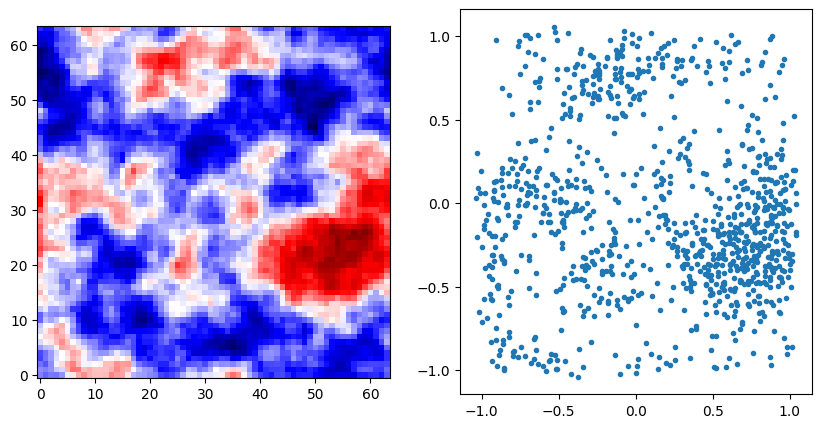

In [5]:
# Define target

bounds = None
sim = Simulator(bounds = None)
sample0 = sim.sample()

plt.figure(figsize = (10, 5))
delta = sample0['delta']
plt.subplot(121)
plt.imshow(delta, cmap = 'seismic', origin = 'lower')
plt.subplot(122)
points = sample0['points']
plt.scatter(points[:,0], points[:,1], marker='.')

  0%|                                                    | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_4016005/1797971689.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()
100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 223.96it/s]


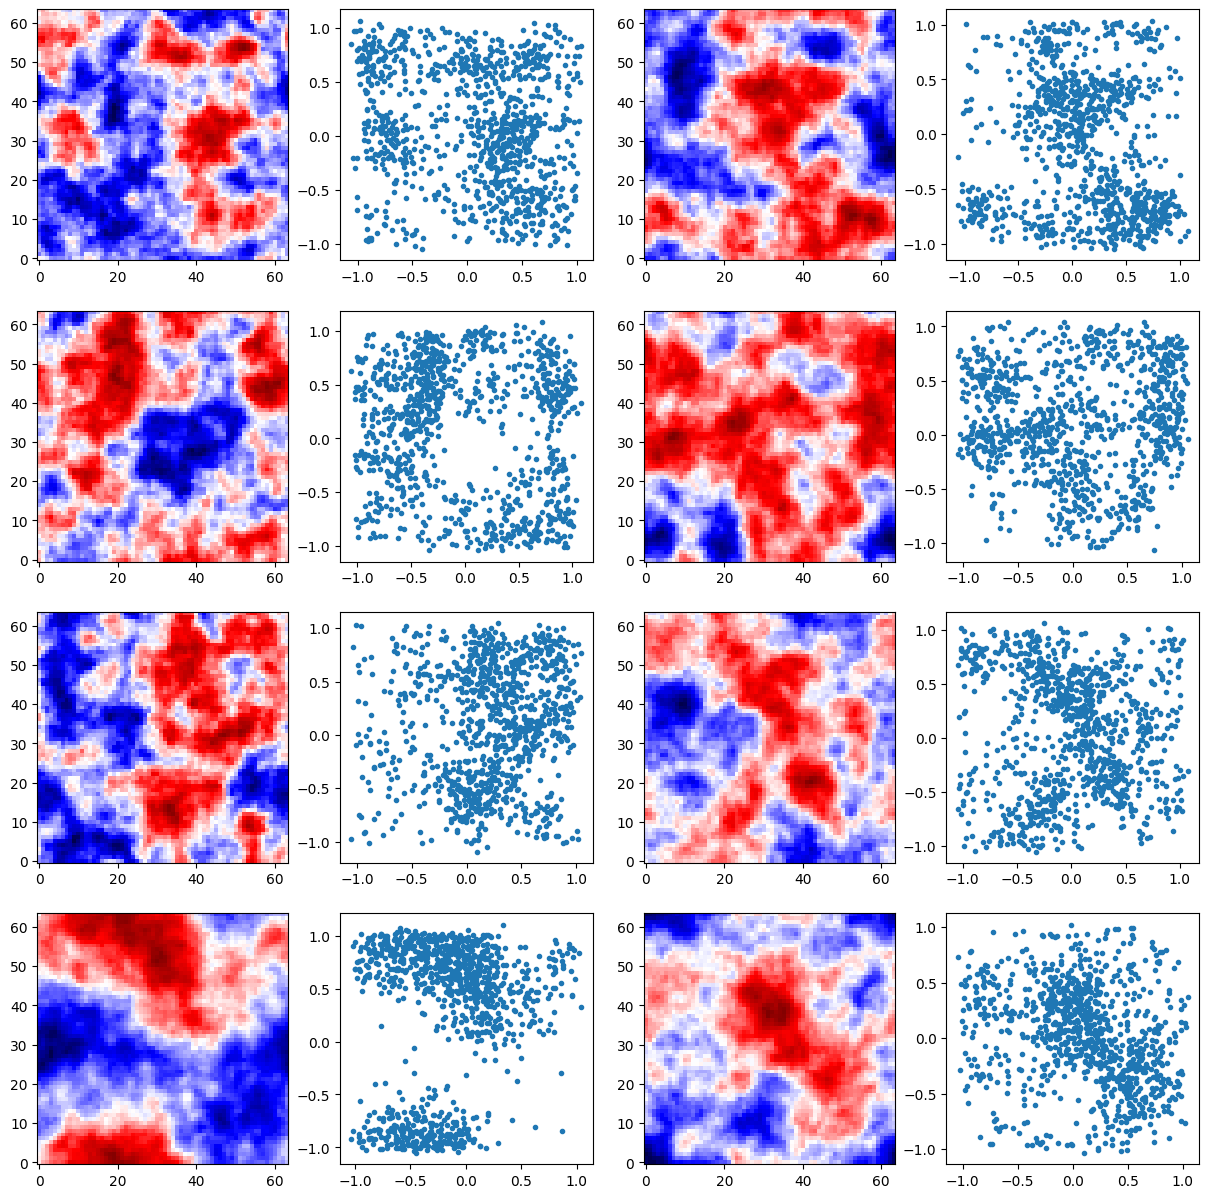

In [6]:
# Training data examples
sim = Simulator(bounds = bounds)
samples = sim.sample(16)
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i*2+1)
    plt.imshow(samples[i]['delta'], cmap = 'seismic', origin='lower')
    points = samples[i]['points']
    plt.subplot(4, 4, i*2+2)
    plt.scatter(points[:,0], points[:,1], marker='.')

### Networks

In [7]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(in_channels, 256),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(out_channels)
        )
        self.bias = Parameter(torch.Tensor(out_channels))

    def forward(self, x, g, edge_index, n_batch):
        out = self.propagate(edge_index, size=(len(x), 4096*n_batch), x=x, g=g.repeat(n_batch, 1))#, norm=norm)
        out += self.bias
        return out

    def message(self, x_j, g_i):
        d = torch.norm(x_j - g_i, dim = 1)  # Summary: the distance to the nearest galaxy
        return d.view(-1, 1)

In [8]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(64*64, 'delta')
        self.g = GCNConv(3, 1)
        self.u = swyft.deps.UNet(1, 1, hidden_channels = 8)

    def embed(self, points, edge_index, n_points, n_edges):
        x, ei, ptr = batch(points, edge_index, n_points, n_edges, num_output_points=64*64)
        nb = len(points)
        g = sim.target.to(points.device)
        out = self.g(x, g, ei, nb).view(nb, 64, 64, -1)[..., 0]
        #out = self.u(out.unsqueeze(-3)).squeeze(-3)
        return out

    def forward(self, A, B):
        points = A['points']
        edge_index = A['edge_index']
        n_points = A['n_points']
        n_edges = A['n_edges']
        outA = self.embed(points, edge_index, n_points, n_edges)

        points = B['points']
        edge_index = B['edge_index']
        n_points = B['n_points']
        n_edges = B['n_edges']
        outB = self.embed(points, edge_index, n_points, n_edges)
        
        zB = B['delta']
        logratios = self.logratios(outA.view(-1, 64*64), outB.view(-1, 64*64), zB.view(-1, 64*64))
        return logratios

### Training

In [9]:
# Simulate training data

sim = Simulator(bounds = bounds)
samples = sim.sample(1_000)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_4016005/1797971689.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()
100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 315.48it/s]


In [10]:
# Train networks (if the loss remains close to 0, please re-run)

trainer = swyft.SwyftTrainer(accelerator = 'cuda', devices=1, max_epochs = 2, precision = 64)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0.0], num_workers = 0, batch_size = 32)
network = Network()
trainer.fit(network, dm)

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/cweniger/.pyenv/versions/3.10.11/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` pa

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/tmp/ipykernel_4016005/723670652.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_points = torch.tensor(n_points)
/tmp/ipykernel_4016005/723670652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points)
/tmp/ipykernel_4016005/723670652.py:9: UserW

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  78%|█████████▍  | 25/32 [00:04<00:01,  5.05it/s, loss=-461, v_num=158]
Validation: 0it [00:00, ?it/s]
Epoch 0:  97%|███████████▋| 31/32 [00:05<00:00,  5.21it/s, loss=-461, v_num=158]
Epoch 0: 100%|█| 32/32 [00:06<00:00,  5.25it/s, loss=-461, v_num=158, val_loss=-
Epoch 1:  78%|▊| 25/32 [00:04<00:01,  5.20it/s, loss=-557, v_num=158, val_loss=-
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/7 [00:00<?, ?it/s]
Epoch 1:  81%|▊| 26/32 [00:04<00:01,  5.21it/s, loss=-557, v_num=158, val_loss=-
Epoch 1:  84%|▊| 27/32 [00:05<00:00,  5.22it/s, loss=-557, v_num=158, val_loss=-
Epoch 1:  88%|▉| 28/32 [00:05<00:00,  5.34it/s, loss=-557, v_num=158, val_loss=-
Epoch 1:  91%|▉| 29/32 [00:05<00:00,  5.36it/s, loss=-557, v_num=158, val_loss=-
Epoch 1:  94%|▉| 30/32 [00:05<00:00,  5.35it/s, loss=-557, v_num=158, val_loss=-
Epoch 1:  97%|▉| 31/32 [00:05<00:00,  5.31it/s, loss=-557, v_num=158, val_loss=-
Epoch 1: 100%|█| 32/32 [00:05<00:00,  5.38it/s,

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|█| 32/32 [00:05<00:00,  5.35it/s, loss=-557, v_num=158, val_loss=-


### Evaluation and sampling from posterior

In [11]:
GAMMA = 0.1
network.cpu()
y = network.embed(torch.tensor(sample0['points']).unsqueeze(0).double(), torch.tensor(sample0['edge_index']).unsqueeze(0), torch.tensor(sample0['n_points']).unsqueeze(0), torch.tensor(sample0['n_edges']).unsqueeze(0))[0].flatten()
prior = sim.powersampler.get_prior_Q_factors(lambda k: 1e6*3*(k/0.5)**-4)
prior = (prior[0], prior[1].cuda(), prior[2])
network.cuda()
y = y.cuda()
x0 = network.logratios.get_MAP(y, prior, gamma = GAMMA).view(64, 64).cpu().detach()


/tmp/ipykernel_4016005/723670652.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_points = torch.tensor(n_points)
/tmp/ipykernel_4016005/723670652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points)
/tmp/ipykernel_4016005/723670652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index)
/tmp/ipykernel_4016005/723670652.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad

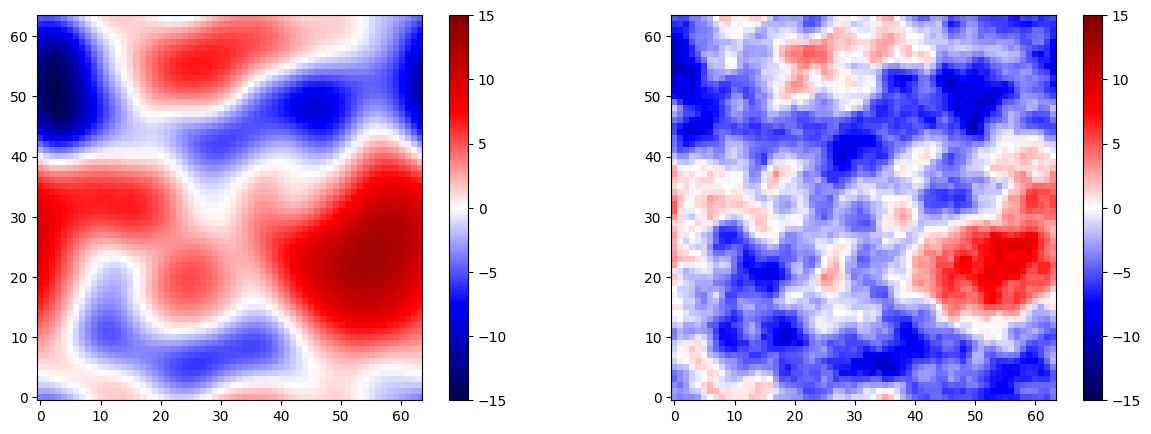

In [12]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.imshow(x0, origin = 'lower', cmap = 'seismic', vmin = -15, vmax = 15)
plt.colorbar()
plt.subplot(122)
plt.imshow(sample0['delta'], origin='lower', cmap = 'seismic', vmin = -15, vmax = 15)
plt.colorbar()

In [13]:
draws = network.logratios.get_noise_samples_GEDA(10, prior, steps = 300, reset = True, gamma = GAMMA)
bounds = [(x0.view(64, 64).cpu().detach() + draws[i].view(64, 64).cpu()).numpy() for i in range(len(draws))]
bounds = np.array(bounds)

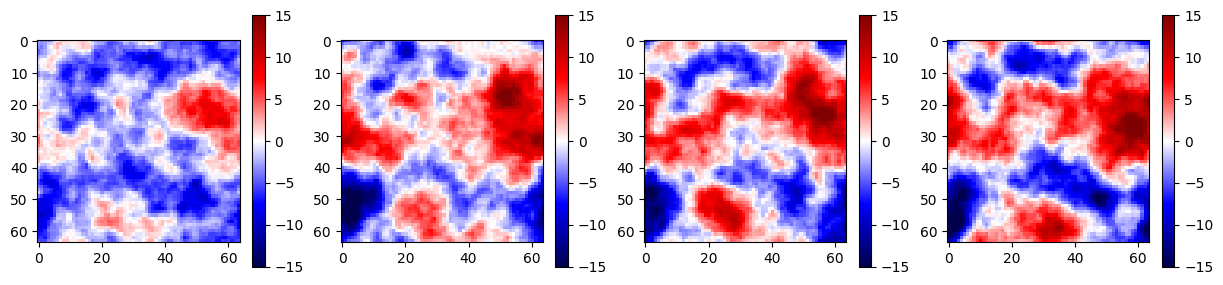

In [14]:
v = 15
plt.figure(figsize = (15, 15))
for i in range(4):
    plt.subplot(4, 4, i+1)
#    plt.imshow(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu(), cmap = 'seismic', vmin = -v, vmax = v)
    if i == 0:
        plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()